In [1]:
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from datasets.SHHS_dataset_timeonly import SHHS_dataset_1, EEGdataModule

from models.logistic_regression import LogisticRegression
from models.simclr_model import SimCLR
from models.supervised_model import SupervisedModel
import torch
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from argparse import Namespace
from copy import deepcopy
from utils.helper_functions import load_model, SimCLRdataModule

## Define dataset: 10 patients for training, 5 for validation and 30 for testing


In [2]:
data_args = {
  "DATA_PATH": "../../thesis01/data/",
  "data_split": [2, 1],
  "first_patient": 1,
  "num_patients_train": 15,
  "num_patients_test": 30,
  "batch_size": 64,
  "num_workers": 12
}

device = torch.device('cpu')
dm = EEGdataModule(**data_args)  # Load datamodule
dm.setup()

Couldn't find file at path:  ../../thesis01/data/n0014_eeg.mat


## Run data through the pretrained SimCLR encoder to get the representations
- The SimCLR model was pretrained on 100 patients (+50 for validation)

In [3]:
encoder_path = "../trained_models/cnn_simclr01.ckpt"
pretrained_model = load_model(SimCLR, encoder_path)  # Load pretrained simclr model
simclr_dm = SimCLRdataModule(pretrained_model, dm, data_args['batch_size'], data_args['num_workers'], device)

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
  rank_zero_warn(


  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/447 [00:00<?, ?it/s]

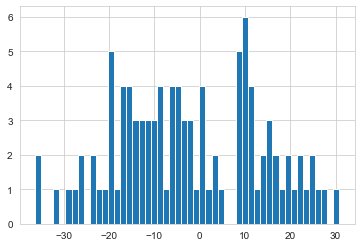

In [6]:
## Analyse the features: histogram and t-SNE plot
feature = next(iter(simclr_dm.train_dataloader()))[0][0]
plt.hist(np.asarray(feature), bins=50)
plt.show()

In [ ]:
tsne = TSNE(n_components=2, n_iter=300, verbose=1, perplexity=125)
x = torch.cat(list(dm.train_dataloader())[0])
x, y = train_ds.tensors
tsne_results = tsne.fit_transform(x)

In [ ]:
df = pd.DataFrame()
df['comp-1'] = tsne_results[:,0]
df['comp-2'] = tsne_results[:,1]
df["y"] = y
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)

## Train a logistic classifier on top


In [8]:
logistic_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "logistic_on_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "None",
  "encoder_hparams": {},

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 15
  },
  "optim_hparams": {
    "lr": 1e-3,
    "weight_decay": 1e-4
  }
}
from trainers.train_supervised import train_supervised
model, res = train_supervised(Namespace(**logistic_args), device=device, dm=simclr_dm)
print(res)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(
Missing logger folder: checkpoints\logistic_on_simclr\lightning_logs

  | Name        | Type             | Params
-------------------------------------------------
0 | net         | Sequential       | 505   
1 | loss_module | C

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

{'test': 0.6778551936149597, 'val': 0.7535503506660461}


## Train a supervised model with the same dataset for comparison


In [10]:
supervised_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "supervised_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "CNN_head",
  "encoder_hparams": {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
  },

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 15
  },
  "optim_hparams": {
    "lr": 1e-3,
    "weight_decay": 1e-4
  }
}
sup_model, sup_res = train_supervised(Namespace(**supervised_args), device, dm=dm)
print(sup_res)

Global seed set to 42


Couldn't find file at path:  ../../thesis01/data/n0014_eeg.mat


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(
Missing logger folder: checkpoints\supervised_simclr\lightning_logs

  | Name        | Type             | Params
-------------------------------------------------
0 | net         | Sequential       | 2.4 M 
1 | loss_module | CrossEntropyLoss | 0    

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

{'test': 0.6464247107505798, 'val': 0.7070133090019226}


## Finetuned supervised model

In [12]:
supervised_args['save_name'] = "finetuned_simclr"
fine_tuned_model, fine_tuned_res = train_supervised(Namespace(**supervised_args), device, dm=dm, pretrained_encoder=deepcopy(pretrained_model.f))
print(sup_res)

Global seed set to 42


Couldn't find file at path:  ../../thesis01/data/n0014_eeg.mat


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(
Missing logger folder: checkpoints\finetuned_simclr\lightning_logs

  | Name        | Type             | Params
-------------------------------------------------
0 | net         | Sequential       | 2.4 M 
1 | loss_module | CrossEntropyLoss | 0     

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
C:\Users\tomsm\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

{'test': 0.6464247107505798, 'val': 0.7070133090019226}
